In [1]:
# By some reason I do have strange error with torchtext. In order to resolve
# poetry run pip uninstall -y torchtext torch torchvision torchaudio
# poetry run pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 --index-url https://download.pytorch.org/whl/cu121
# poetry run pip install torchtext==0.17.0
# poetry run pip install seqeval

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"

# Set your W&B token
os.environ["WANDB_API_KEY"]="???"

import calendar

import gensim
import nltk
import spacy
import re
import evaluate
import torch
import torch.nn as nn
import pandas as pd
import numpy as np 

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
from itertools import chain
from typing import List, Tuple
from pprint import pprint
from joblib import Parallel
from joblib import delayed
from IPython.display import Image

%matplotlib inline

In [37]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/vsydorskyi/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Sequence Labeling. RNNs. Intro to Lightning.
# Agenda

1. [Sequence Labeling. Named Entity Recognition](#nertask)
2. [Data preparation](#prepare)
3. [Recurrent Neural Networks (RNN, GRU, LSTM)](#rnn)
4. [Data Flow: Dataset, DataCollator and DataLoader](#dataflow)
5. [NER Practice. Lightning](#nerpractice)

<a id='nertask'></a>
# 1. Sequence Labeling. Named Entity Recognition example

## Problem Statement

Let the input be a sequence of tokens:

$$
X = \left( x_1, x_2, \ldots, x_T \right)
$$

where each $x_t$ represents an individual token (e.g., a word in a sentence) and $T$ is the sequence length.

The objective of sequence labeling is to assign a corresponding label sequence:

$$
Y = \left( y_1, y_2, \ldots, y_T \right)
$$

where each $y_t$ is selected from a finite set of labels $\mathcal{L}$.

The mapping function is defined as:

$$
f: X \rightarrow Y
$$

Often, the task is formulated in a probabilistic framework. For a given model parameterized by $\theta$, we define the conditional probability of a label sequence $Y$ given $X$ as:

$$
P(Y \mid X; \theta)
$$

Training the model on a dataset $\{(X^{(i)}, Y^{(i)})\}_{i=1}^{N}$ typically involves maximizing the likelihood:

$$
\mathcal{L}(\theta) = \prod_{i=1}^{N} P\left(Y^{(i)} \mid X^{(i)}; \theta\right)
$$

or equivalently the log-likelihood:

$$
\log \mathcal{L}(\theta) = \sum_{i=1}^{N} \log P\left(Y^{(i)} \mid X^{(i)}; \theta\right)
$$

This formalism underlies many sequence labeling tasks such as part-of-speech tagging or named entity recognition.

---

## Named Entity Recognition (NER) as a Sequence Labeling Task

Named Entity Recognition is a classic example of a sequence labeling task where the goal is to identify and classify named entities (such as persons, organizations, locations, etc.) within a sentence.

### Example

Consider the sentence:

> "Barack Obama was born in Hawaii."

We first represent the sentence as a sequence of tokens:

$$
X = [\text{Barack},\ \text{Obama},\ \text{was},\ \text{born},\ \text{in},\ \text{Hawaii},\ \text{.}]
$$

Using a common BIO tagging scheme, we assign labels to each token:

- **B-PER**: Beginning of a person name  
- **I-PER**: Inside of a person name  
- **B-LOC**: Beginning of a location name  
- **O**: Outside any named entity  

The corresponding label sequence might be:

$$
Y = [\text{B-PER},\ \text{I-PER},\ \text{O},\ \text{O},\ \text{O},\ \text{B-LOC},\ \text{O}]
$$

Thus, the mapping function for NER assigns:

$$
\text{f(“Barack”)} \rightarrow \text{B-PER}, \quad \text{f(“Obama”)} \rightarrow \text{I-PER}, \quad \text{f(“Hawaii”)} \rightarrow \text{B-LOC}
$$

while non-entity words receive the label $\text{O}$.

> **TODO**: Read about different tagging schemes e.g. BIO, IO, BILOU

<a id='prepare'></a>
# 2. Data preparation

### uk_geo_dataset
Ukrainian dataset [Corpora Ukrainian](https://huggingface.co/datasets/ukr-models/Ukr-Synth).
It contains approximately 1M text samples with location and organization entities.


In [2]:
from huggingface_hub import snapshot_download

repo = "ukr-models/Ukr-Synth"
local_dir = "../data/ukr-data-ner"

# Download the model to the specified directory
snapshot_download(
    repo_type='dataset',
    repo_id=repo,
    local_dir=local_dir,
    allow_patterns=["*"]  # Adjust to download specific files if needed
)

print(f"Downloaded to {local_dir}")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

data/dev.conllu.gz:   0%|          | 0.00/2.53M [00:00<?, ?B/s]

data/train.conllu.gz:   0%|          | 0.00/251M [00:00<?, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

Ukr-Synth.py: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Downloaded to ../data/ukr-data-ner


In [3]:
import gzip
from tqdm.autonotebook import tqdm

def read_conll_file(filepath, nrows=10):
    sentences = []
    current_sentence = []
    sentence_counts = 0
    with gzip.open(filepath, 'rt', encoding='utf-8') as file:
        for line in file:
            line = line.strip()
            # A blank line indicates the end of a sentence
            if not line:
                if current_sentence:
                    sentences.append(current_sentence)
                    sentence_counts += 1
                    current_sentence = []
            else:
                # Split the line into its fields (e.g., token, POS, label, etc.)
                parts = line.split()
                current_sentence.append(parts)
            if sentence_counts >= nrows:
                break
        # If the file doesn't end with a newline, add the last sentence.
        if current_sentence:
            sentences.append(current_sentence)
            
    return sentences

# Example usage:
train_filepath = "../data/ukr-data-ner/data/train.conllu.gz"
valid_filepath = "../data/ukr-data-ner/data/dev.conllu.gz"
train_data = read_conll_file(train_filepath, nrows=200_000)
valid_data = read_conll_file(valid_filepath, nrows=10_000)
print("Number of train sentences:", len(train_data))
print("Number of valid sentences:", len(valid_data))
print("Sentence example:", train_data[1])

Number of train sentences: 200000
Number of valid sentences: 10000
Sentence example: [['#', 'sent_id', '=', '1'], ['#', 'text', '=', 'А', 'поки', 'що', 'починали', 'цвісти', 'троянди,', 'випускники', 'складали', 'іспити,', 'учні', 'відпочивали', 'в', 'пришкільному', 'таборі,', 'а', 'директор', 'Володимир', 'Хоботов', 'марно', 'оббивав', 'пороги', 'в', 'пошуках', 'транспорту.'], ['1', 'А', '_', 'CCONJ', 'CCONJ', 'SpaceAfter=Yes', '4', 'cc', '_', 'O'], ['2', 'поки', '_', 'ADV', 'ADV', 'PronType=Rel|SpaceAfter=Yes', '4', 'advmod', '_', 'O'], ['3', 'що', '_', 'PART', 'PART', 'SpaceAfter=Yes', '2', 'discourse', '_', 'O'], ['4', 'починали', '_', 'VERB', 'VERB', 'Aspect=Imp|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin|SpaceAfter=Yes', '0', 'root', '_', 'O'], ['5', 'цвісти', '_', 'VERB', 'VERB', 'Aspect=Imp|VerbForm=Inf|SpaceAfter=Yes', '4', 'xcomp', '_', 'O'], ['6', 'троянди', '_', 'NOUN', 'NOUN', 'Animacy=Inan|Case=Nom|Gender=Masc|Number=Plur|SpaceAfter=No', '4', 'nsubj', '_', 'O'], ['7', ',

In [4]:
columns = ['ID', 'FORM', 'LEMMA', 'UPOS', 'XPOS', 'FEATS', 'HEAD', 'DEPREL', 'DEPS', 'MISC']

sentence = pd.DataFrame(train_data[1][2:], columns=columns)
sentence

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC
0,1,А,_,CCONJ,CCONJ,SpaceAfter=Yes,4,cc,_,O
1,2,поки,_,ADV,ADV,PronType=Rel|SpaceAfter=Yes,4,advmod,_,O
2,3,що,_,PART,PART,SpaceAfter=Yes,2,discourse,_,O
3,4,починали,_,VERB,VERB,Aspect=Imp|Mood=Ind|Number=Plur|Tense=Past|Ver...,0,root,_,O
4,5,цвісти,_,VERB,VERB,Aspect=Imp|VerbForm=Inf|SpaceAfter=Yes,4,xcomp,_,O
5,6,троянди,_,NOUN,NOUN,Animacy=Inan|Case=Nom|Gender=Masc|Number=Plur|...,4,nsubj,_,O
6,7,",",_,PUNCT,PUNCT,SpaceAfter=Yes,9,punct,_,O
7,8,випускники,_,NOUN,NOUN,Animacy=Anim|Case=Nom|Gender=Masc|Number=Plur|...,9,nsubj,_,O
8,9,складали,_,VERB,VERB,Aspect=Imp|Mood=Ind|Number=Plur|Tense=Past|Ver...,4,parataxis,_,O
9,10,іспити,_,NOUN,NOUN,Animacy=Inan|Case=Acc|Gender=Masc|Number=Plur|...,9,obj,_,O


# CoNLL-U Format Explained

A file in the CoNLL-U format is typically structured with two types of lines: **comment lines** and **token lines**.

---

## 1. Comment Lines

- **Comment lines** start with the `#` character.
- They provide metadata about the sentence.
  - **Example 1:**  
    ```plaintext
    # sent_id = 1
    ```  
    This line indicates the sentence identifier.
  
  - **Example 2:**  
    ```plaintext
    # text = А поки що починали цвісти троянди, випускники складали іспити, учні відпочивали в пришкільному таборі, а директор Володимир Хоботов марно оббивав пороги в пошуках транспорту.
    ```  
    This line shows the full text of the sentence.

---

## 2. Token Lines

After the comment lines, each subsequent line (until a blank line) represents one token in the sentence. Each token line contains **10 columns** separated by whitespace (or tabs). Here’s the breakdown:

1. **ID**  
   - Token index (starting at 1).  
   - *Example:* `1`

2. **FORM**  
   - The actual word or punctuation as it appears in the sentence.  
   - *Example:* `А`

3. **LEMMA**  
   - The lemma or base form of the token.  
   - *Example:* `_` (underscore means it is not provided)

4. **UPOS**  
   - Universal part-of-speech tag (e.g., `NOUN`, `VERB`, `CCONJ`).  
   - *Example:* `CCONJ`

5. **XPOS**  
   - Language-specific part-of-speech tag.  
   - *Example:* `CCONJ`

6. **FEATS**  
   - Morphological features (e.g., tense, number, case) in a pipe-separated format.  
   - *Example:* `SpaceAfter=Yes`

7. **HEAD**  
   - The index of the syntactic head (governor of the current token in the dependency tree).  
   - *Example:* `4`

8. **DEPREL**  
   - Dependency relation to the head (e.g., `nsubj`, `obj`, `cc`).  
   - *Example:* `cc`

9. **DEPS**  
   - Enhanced dependency graph representation; often `_` if not used.  
   - *Example:* `_`

10. **MISC**  
    - Miscellaneous information (could include space handling, named entity tags, etc.).  
    - *Example:* `O`

> **TODO**: Read format docs https://universaldependencies.org/docs/format.html

In [5]:
import collections

def get_label_distribution(sentences, label_index=9):
    label_counter = collections.Counter()
    for sentence in sentences:
        for token in sentence:
            if token[0].startswith('#') or len(token) != 10:
                continue
            label = token[label_index]
            label_counter[label] += 1
    return label_counter

label_dist = get_label_distribution(train_data)

print("Unique labels:")
print(list(label_dist.keys()))

print("\nLabel distribution:")
for label, count in label_dist.items():
    print(f"{label}: {count}")

Unique labels:
['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

Label distribution:
O: 3256383
B-PER: 57101
I-PER: 30937
B-ORG: 53905
I-ORG: 48344
B-LOC: 67384
I-LOC: 15892


In [6]:
def yield_tokens(data):
    for sentence in data:
        tokens = [row[1] for row in sentence if not row[0].startswith('#')]
        yield tokens

# Build the vocabulary using torchtext's utility
vocab = build_vocab_from_iterator(yield_tokens(train_data + valid_data), specials=["<unk>", "<pad>"])
vocab.set_default_index(vocab["<unk>"])

# Define a tokenizer that extracts tokens from a given sentence (ignoring metadata rows)
def simple_tokenizer(sentence):
    return [row[1] for row in sentence if not row[0].startswith('#')]

# Example usage:
tokens = simple_tokenizer(train_data[1])
token_indices = [vocab[token] for token in tokens]

print("Tokens:", tokens)
print("Token indices:", token_indices)

Tokens: ['А', 'поки', 'що', 'починали', 'цвісти', 'троянди', ',', 'випускники', 'складали', 'іспити', ',', 'учні', 'відпочивали', 'в', 'пришкільному', 'таборі', ',', 'а', 'директор', 'Володимир', 'Хоботов', 'марно', 'оббивав', 'пороги', 'в', 'пошуках', 'транспорту', '.']
Token indices: [62, 241, 11, 14934, 44930, 22755, 2, 13262, 20319, 13131, 2, 4773, 19783, 6, 211139, 8882, 2, 24, 737, 243, 160236, 11513, 73106, 59650, 6, 7276, 1131, 3]


In [7]:
len(vocab)

232984

In [8]:
vocab.lookup_indices(["поки", "що", "покищо", "покищо#", "<unk>", "<pad>"])

[241, 11, 103135, 0, 0, 1]

In [9]:
token_freqs = collections.Counter(token for tokens in yield_tokens(train_data) for token in tokens)

# Get the 30 most common tokens
top30 = token_freqs.most_common(30)
top30

[(',', 241468),
 ('.', 197222),
 ('"', 56487),
 ('на', 55117),
 ('в', 46747),
 ('і', 42945),
 ('у', 42879),
 ('-', 40398),
 ('з', 38501),
 ('що', 34549),
 ('не', 31999),
 ('та', 27169),
 ('до', 24115),
 ('за', 19184),
 ('«', 15318),
 ('»', 14810),
 ('–', 13675),
 ('про', 12716),
 ('це', 12170),
 ('У', 11854),
 ('для', 11686),
 ('від', 10870),
 ('а', 9884),
 ('як', 9037),
 (':', 8449),
 ('України', 8296),
 ('із', 8124),
 ('які', 8054),
 ('його', 7867),
 ('(', 7866)]

<a id='rnn'></a>
# 3. Recurrent Neural Networks (RNN, GRU, LSTM)

## Recurrent Neural Networks

In a recurrent neural network, we store the output activations from one or more of the layers of the network. Often, these are hidden layer activations. Then, the next time we feed an input example to the network, we include the previously stored outputs as additional inputs. You can think of the additional inputs as being concatenated to the end of the "normal" inputs to the previous layer. For example, if a hidden layer had 10 regular input nodes and 128 hidden nodes in the layer, then it would actually have 138 total inputs (assuming you are feeding the layer's outputs into itself rather than into another layer). Of course, the very first time you try to compute the network output, you'll need to fill in those extra 128 inputs with 0s or something.

Source: [Quora](https://www.quora.com/What-is-a-simple-explanation-of-a-recurrent-neural-network).

<img src="https://cdn-images-1.medium.com/max/1600/1*NKhwsOYNUT5xU7Pyf6Znhg.png">

Source: [Medium](https://medium.com/ai-journal/lstm-gru-recurrent-neural-networks-81fe2bcdf1f9).

Let me give you the best explanation of Recurrent Neural Networks I found online: https://www.youtube.com/watch?v=UNmqTiOnRfg&t=3s.

Now, even though RNNs are pretty powerful, they suffer from the **Vanishing gradient problem**, which hinders them from using long-term information. For instance, they are suitable for storing memory 3-4 instances of past iterations, but a larger number of instances don't provide good results. So, we don't use just regular RNNs. Instead, we use a better variation of RNNs: **Long Short-Term Networks (LSTMs)**.

### What is Vanishing Gradient problem?

The vanishing gradient problem is a difficulty in training artificial neural networks with gradient-based learning methods and backpropagation. In such methods, each of the neural network's weights receives an update proportional to the partial derivative of the error function with respect to the current weight in each training iteration. The problem is that, in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. In the worst case, this may completely stop the neural network from further training. As one example of the problem cause, traditional activation functions such as the hyperbolic tangent function have gradients in the range (0, 1), and backpropagation computes gradients by the chain rule. This fact has the effect of multiplying n of these small numbers to compute gradients of the "front" layers in an n-layer network, meaning that the gradient (error signal) decreases exponentially with n, resulting in the slow training of the front layers.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).

<img src="https://cdn-images-1.medium.com/max/1460/1*FWy4STsp8k0M5Yd8LifG_Q.png">

Source: [Medium](https://medium.com/@anishsingh20/the-vanishing-gradient-problem-48ae7f501257).


> **TODO**: Can you explain **Vanishing gradient problem** mathematically? 

## Long Short Term Memory(LSTM)

**Long short-term memory (LSTM)** units (or blocks) are building blocks for layers of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network. A common LSTM unit comprises a cell, an input gate, an output gate, and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network: that is, they compute an activation (using an activation function) of a weighted sum. Intuitively, they can be thought of as regulators of the flow of values that goes through the connections of the LSTM; hence the denotation "gate". There are connections between these gates and the cell.

The expression "long short-term" refers to the fact that LSTM is a model for short-term memory that can last for a long time. An LSTM is well-suited to classify, process, and predict time series given time lags of unknown size and duration between important events. LSTMs were developed to deal with the exploding and vanishing gradient problem when training traditional RNNs.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory).

<img src="https://cdn-images-1.medium.com/max/1600/0*LyfY3Mow9eCYlj7o.">

Source: [Medium](https://codeburst.io/generating-text-using-an-lstm-network-no-libraries-2dff88a3968).

The best LSTM explanation on the internet: https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235.

Refer to the above link for deeper insights.

LSTM is not the only kind of unit that has taken the world of Deep Learning by storm. We have **Gated Recurrent Units (GRU)**. It's yet to be determined which is better, GRU or LSTM because they have comparable performances. GRUs are easier to train than LSTMs.

## Gated Recurrent Units (GRU)

In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly make use of all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. The reset gate determines how to combine new input with previous memory, and the update gate determines how much of the previous state to keep. The update gate in GRU is what the input and forget gates were in LSTM. We don't have the second non-linearity in GRU before calculating the output, nor do they have the output gate.

Source: [Quora](https://www.quora.com/Whats-the-difference-between-LSTM-and-GRU-Why-are-GRU-efficient-to-train).


$h_{t-1}$ is the previous hidden state and $x_t$ is the current input.

---

**Reset Gate Computation**

$$
r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r)
$$

- $W_r$ and $U_r$ are weight matrices.
- $b_r$ is a bias vector.
- $\sigma$ is the sigmoid activation function.

---

**Candidate Hidden State**

$$
\tilde{h}_t = \tanh \bigl(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h \bigr)
$$

- $W_h$ and $U_h$ are weight matrices.
- $b_h$ is a bias vector.
- $\odot$ denotes element-wise multiplication.
- $\tanh$ is the hyperbolic tangent function.

---

**Tanh Node**

The diagram’s tanh node produces $\tilde{h}_t$, the candidate hidden state.

---

**Update Gate Computation**

$$
z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z)
$$

- $W_z$ and $U_z$ are weight matrices.
- $b_z$ is a bias vector.

---

**Final Hidden State Update**

$$
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
$$

- The update gate $z_t$ balances the previous hidden state $h_{t-1}$ and the new candidate $\tilde{h}_t$.

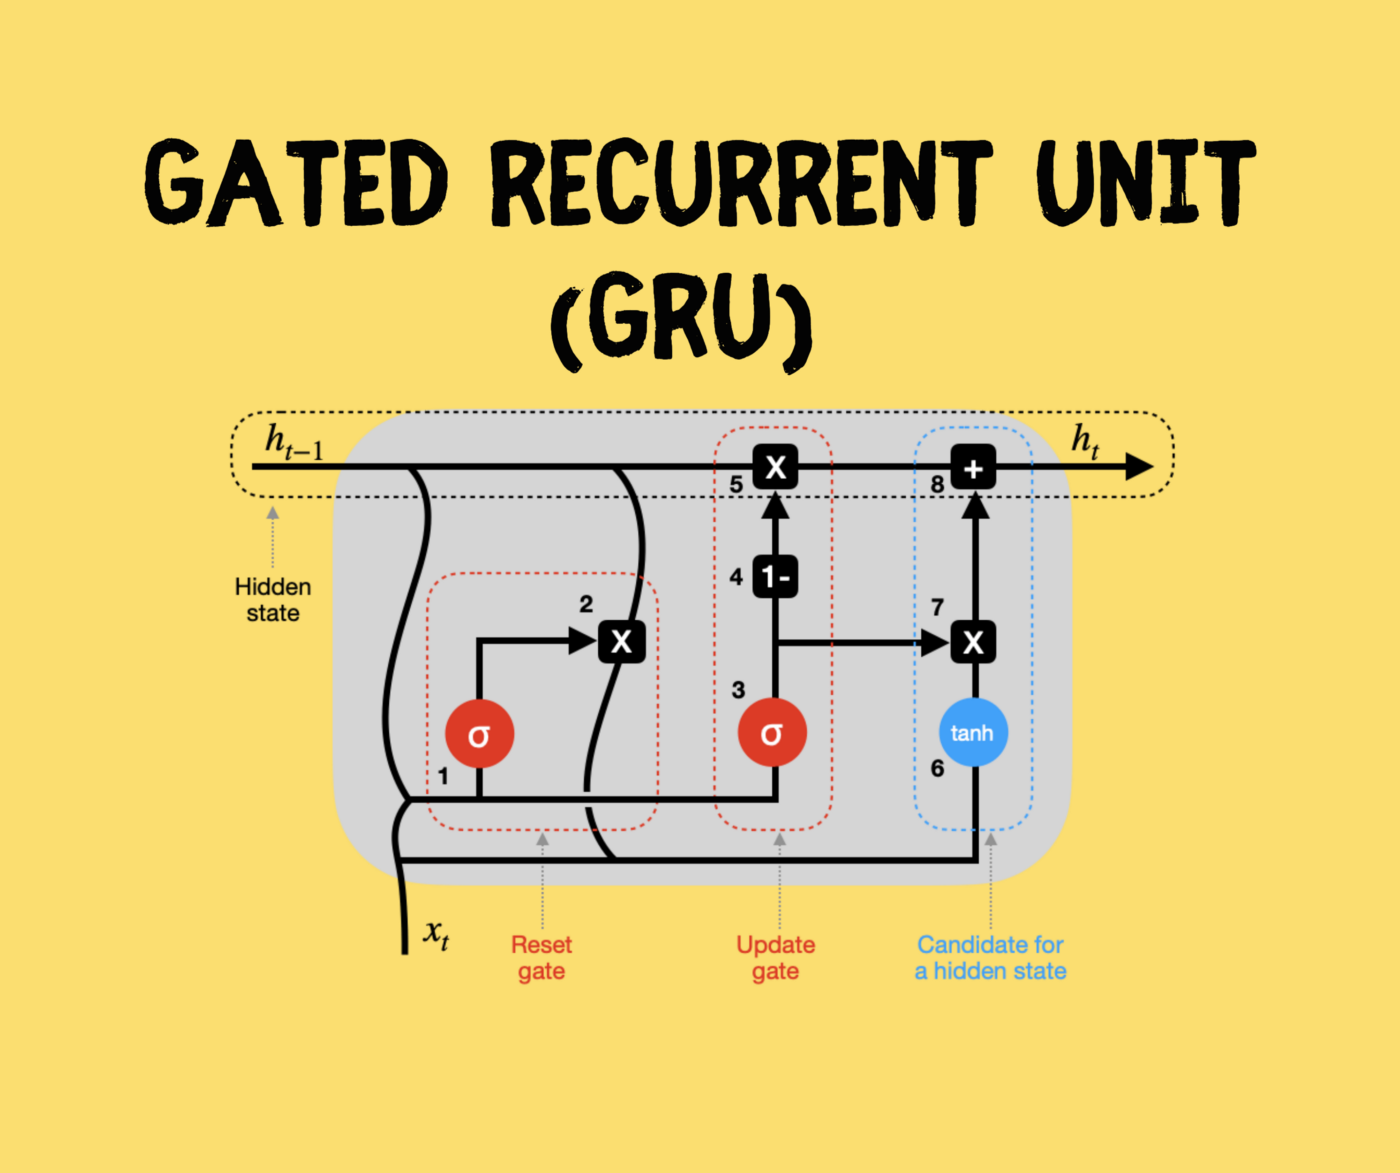

> **TODO**: read about modern SOTA architectures that incorporate recurrence e.g. MAMBA, SAMBA, RecurrentGemma

## All Together

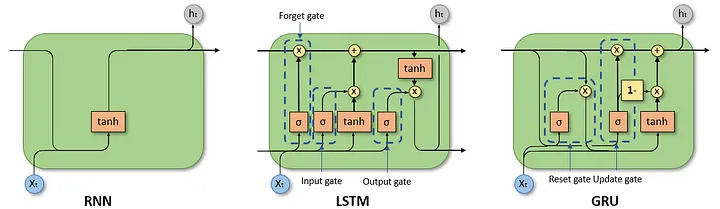

In [10]:
Image("images/1 B0q2ZLsUUw31eEImeVf3PQ.jpg")

<a id='Short_Explanation_what_is_nn_Embedding'></a>
## Short Explanation of what is nn.Embedding

Assume we want to build our own Word Embeddings. How can we do it?

1. Tokenize text - split it into separate entities (words and symbols).
2. Build Vocabulary (recall Bag of Words). So now we can assign some int (long) number to each word.
3. Construct some random matrix with dimension $vocab\_size \times embedding\_dimension$.
4. Now, we can take a particular vector from the built matrix for each word.

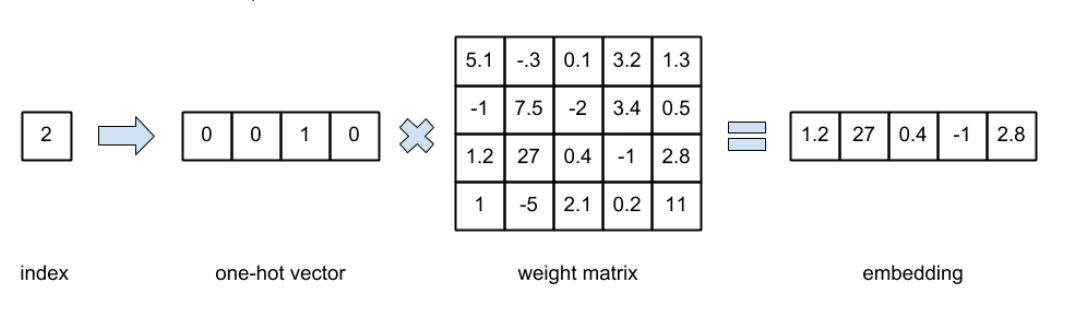

In [11]:
Image("images/Screenshot from 2023-10-16 12-53-17.png")

Here is the full pipeline

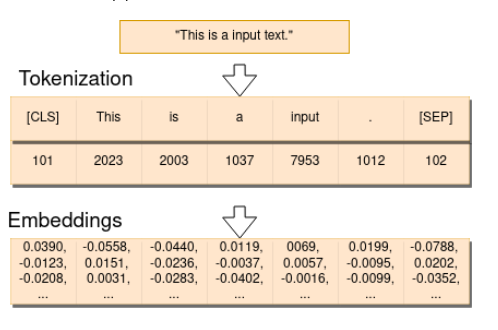

In [12]:
Image("images/Screenshot from 2023-10-16 12-53-30.png")

This matrix consists of trainable parameters and will be optimized during training.

> **TODO**: read about special tokens : `<CLS>`, `<SEP>`.

In [13]:
torch.manual_seed(42)
torch.backends.cuda.deterministic = True

if torch.cuda.is_available():
    global_device = "cuda"
else:
    global_device = "cpu"
print("Training device:", global_device)

Training device: cuda


In [14]:
# Lets build or RNN Class 

class UniversalRNN(nn.Module):
    
    def __init__(
        self,
        num_embeddings,
        out_channels,
        rnn_channels=512,
        rnn_type=nn.GRU,
        n_rnns=1,
        bidirectional=True,
        average_type=None,
        dropout_rate=0.3
    ):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(num_embeddings, rnn_channels)
        # TODO: What is bidirectional ? Try unidirectional
        self.rnns = rnn_type(
            rnn_channels, 
            rnn_channels, 
            bidirectional=bidirectional, 
            num_layers=n_rnns,
            batch_first=True
        )
        if not (average_type is None or average_type in ["mean", "last"]):
            raise ValueError(f"{average_type} is nit supported average_type")
        self.average_type = average_type
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(
                rnn_channels * 2 if bidirectional else rnn_channels, 
                out_channels, 
            )
        )
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.rnns(x)[0]
        if self.average_type is None:
            x = self.classifier(x)
        else:
            # Dimension reminder : [Batch, Time Dimension, Channels]
            if self.average_type == "mean":
                x = x.mean(1)
            elif self.average_type == "last":
                x = x[:,-1,:]
            x = self.classifier(x)
        return x

> **TODO**: Read about Dropout: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

> **TODO**: What is bidirectional ? Try unidirectional

## Bidirectional network
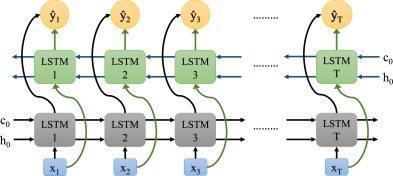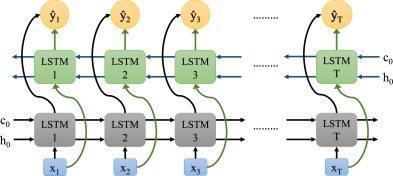]

In [15]:
nn_model = UniversalRNN(128, 2)
nn_model

UniversalRNN(
  (embedding_layer): Embedding(128, 512)
  (rnns): GRU(512, 512, batch_first=True, bidirectional=True)
  (classifier): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=1024, out_features=2, bias=True)
  )
)

<a id='dataflow'></a>
# 4. Data Flow: Dataset, DataCollator and DataLoader

In many modern NLP pipelines, data flows from raw text files to model-ready tensors through three key components:

---

## 1. Dataset

- **Purpose:**  
  The **Dataset** represents the raw data in a structured format. It provides access to individual samples (e.g., sentences, paragraphs) and performs any necessary preprocessing.

- **Responsibilities:**  
  - **Reading raw data:** It loads text data from sources like files, databases, or other data streams.
  - **Preprocessing:** It handles operations like cleaning text, tokenization (splitting text into tokens), and encoding tokens into numerical IDs.
  - **Storing annotations:** For supervised tasks, it holds the labels or target information along with the input text.

- **Usage:**  
  Each sample in the dataset is typically accessed via an index (e.g., `dataset[i]`), and this sample is usually returned as a dictionary with keys such as `"input_ids"`, `"attention_mask"`, and `"label"`.

---

## 2. DataCollator

- **Purpose:**  
  The **DataCollator** takes a list of individual samples (as returned by the Dataset) and collates them into a single batch. Its role is to prepare uniform batches by handling differences in sequence lengths.

- **Responsibilities:**  
  - **Padding/Truncation:** It ensures that all sequences in a batch have the same length by padding them appropriately.
  - **Handling Special Cases:** It may also manage other nuances, such as dealing with variable-length labels or masks.

- **Usage:**  
  The DataCollator is called automatically by the DataLoader when it creates a batch, making sure that each batch is consistent and ready for input to a model.

---

## 3. DataLoader

- **Purpose:**  
  The **DataLoader** serves as an iterator that provides batches of data during model training or evaluation. It orchestrates the sampling, shuffling, and batching of data.

- **Responsibilities:**  
  - **Batching:** It divides the dataset into batches according to a specified batch size.
  - **Shuffling:** It can shuffle the dataset to ensure that the model sees a random order of samples during training.
  - **Parallel Loading:** It can load data in parallel using multiple workers, which improves data throughput and training speed.
  - **Integration with DataCollator:** It leverages the DataCollator to assemble individual samples into properly formatted batches.

- **Usage:**  
  During training, the DataLoader yields one batch at a time (each batch being a dictionary of tensors such as `"input_ids"`, `"attention_mask"`, and `"labels"`), which is then fed into the model.

In [16]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        conll_data,
        dataset_vocab,
        labels_names,
        max_length
    ):
        self.conll_data = conll_data
        self.vocab = dataset_vocab
        self.pad_token_id = self.vocab['<pad>']
        self.max_length = int(max_length)
        self.labels_names = labels_names
        self.label2id = {k: ind for ind, k in enumerate(list(self.labels_names))}
        self.id2label = {v: k for k, v in self.label2id.items()}

    def simple_tokenizer(self, sentence):
        return [row[1] for row in sentence if not row[0].startswith('#')]

    def get_labels(self, sentence):
        return [self.label2id[row[-1]] for row in sentence if not row[0].startswith('#')]
                
    def __getitem__(self, idx):
        current_item = self.conll_data[idx]
        input_ids = self.vocab(self.simple_tokenizer(current_item))
        labels = self.get_labels(current_item)
        return {
            'input_ids': input_ids[:self.max_length],
            'labels': labels[:self.max_length]
        }
    
    def __len__(self):
        return len(self.conll_data)

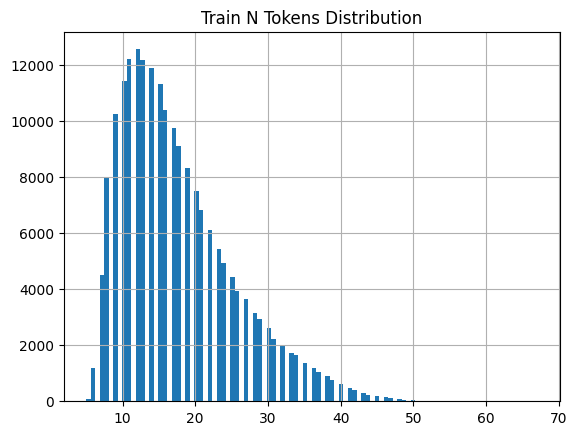

0.99 Quantile of N tokens: 41.0


In [17]:
# Here we want to figure out empirically max_length

train_n_tokens = pd.Series([len(simple_tokenizer(s)) for s in train_data])

plt.title("Train N Tokens Distribution")
train_n_tokens.hist(bins=100)
plt.show()

q99 = np.quantile(train_n_tokens, 0.99)
print(f"0.99 Quantile of N tokens: {q99}")

In [18]:
ds_train = TextDataset(train_data, vocab, list(label_dist.keys()), q99)
ds_valid = TextDataset(valid_data, vocab, list(label_dist.keys()), q99)

In [19]:
print(ds_train[1])

{'input_ids': [62, 241, 11, 14934, 44930, 22755, 2, 13262, 20319, 13131, 2, 4773, 19783, 6, 211139, 8882, 2, 24, 737, 243, 160236, 11513, 73106, 59650, 6, 7276, 1131, 3], 'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0]}


In [20]:
class DataCollatorForTokenClassification:
    def __init__(self, pad_token_id, label_pad_token_id=-100):
        self.pad_token_id = pad_token_id
        self.label_pad_token_id = label_pad_token_id #-100 to ignore tokens in loss computations

    def __call__(self, features):
        # Extract input_ids and labels from the list of feature dictionaries.
        input_ids_list = [f["input_ids"] for f in features]
        labels_list = [f["labels"] for f in features]
        
        # Determine the maximum sequence length in this batch.
        batch_max_length = max(len(ids) for ids in input_ids_list)
        
        # Pad input_ids and labels on the right.
        padded_input_ids = [
            ids + [self.pad_token_id] * (batch_max_length - len(ids))
            for ids in input_ids_list
        ]
        padded_labels = [
            labels + [self.label_pad_token_id] * (batch_max_length - len(labels))
            for labels in labels_list
        ]
        
        # Convert lists to tensors.
        batch_input_ids = torch.tensor(padded_input_ids, dtype=torch.long)
        batch_labels = torch.tensor(padded_labels, dtype=torch.long)
        
        return {"input_ids": batch_input_ids, "labels": batch_labels}

In [21]:
from torch.utils.data import DataLoader

pad_token_id = ds_train.vocab['<pad>']
collator = DataCollatorForTokenClassification(pad_token_id, label_pad_token_id=-100)

dataloader = DataLoader(
    ds_train,
    batch_size=64,
    collate_fn=collator
)

In [22]:
data_iter = iter(dataloader)
first_batch = next(data_iter)
first_batch

{'input_ids': tensor([[ 3472,  4841,   140,  ...,     1,     1,     1],
         [   62,   241,    11,  ...,     1,     1,     1],
         [  223,    58,     2,  ...,     1,     1,     1],
         ...,
         [  185,    54,  8533,  ...,     1,     1,     1],
         [66451,     8,   129,  ...,     1,     1,     1],
         [   62,  4605,  4087,  ...,     1,     1,     1]]),
 'labels': tensor([[   0,    0,    0,  ..., -100, -100, -100],
         [   0,    0,    0,  ..., -100, -100, -100],
         [   0,    0,    0,  ..., -100, -100, -100],
         ...,
         [   0,    0,    0,  ..., -100, -100, -100],
         [   0,    0,    0,  ..., -100, -100, -100],
         [   0,    0,    0,  ..., -100, -100, -100]])}

<a id='nerpractice'></a>
# 5. NER Practice. Lightning

In [24]:
import evaluate

metric = evaluate.load("seqeval")
label_names = ds_train.labels_names
id2label = ds_train.id2label

def compute_metrics(predictions, labels):
    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

In [25]:
def merge_bio_entities(tokens, bio_tags):
    entities = []
    current_entity = None

    for token, tag in zip(tokens, bio_tags):
        if tag.startswith("B-"):
            # Start a new entity; if one is ongoing, save it.
            if current_entity is not None:
                entities.append(current_entity)
            current_entity = {"text": token, "label": tag[2:]}
        elif tag.startswith("I-"):
            # Continue the current entity if it exists and matches the type.
            if current_entity is not None and current_entity["label"] == tag[2:]:
                current_entity["text"] += " " + token
            else:
                # If misaligned, start a new entity.
                current_entity = {"text": token, "label": tag[2:]}
        else:  # tag == "O"
            if current_entity is not None:
                entities.append(current_entity)
                current_entity = None

    # Append any remaining entity.
    if current_entity is not None:
        entities.append(current_entity)
    return entities

In [26]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

from nltk import word_tokenize
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

class TokenClassificationLitModule(pl.LightningModule):
    def __init__(self, num_embeddings, num_labels, learning_rate=1e-3, total_steps=1000):
        super().__init__()
        self.save_hyperparameters()
        self.model = UniversalRNN(
            num_embeddings=num_embeddings, 
            out_channels=num_labels, 
            rnn_channels=512,
            rnn_type=nn.GRU,
            n_rnns=3,
            bidirectional=True,
            dropout_rate=0.3,
            average_type=None
        )
        self.criterion = nn.CrossEntropyLoss(ignore_index=-100)
        # Instance attribute to store validation outputs
        self.val_outputs = []
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        labels = batch["labels"]
        logits = self(input_ids)  # [batch, seq_length, num_labels]
        loss = self.criterion(logits.view(-1, logits.shape[-1]), labels.view(-1))
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        labels = batch["labels"]
        logits = self(input_ids)
        loss = self.criterion(logits.view(-1, logits.shape[-1]), labels.view(-1))
        preds = torch.argmax(logits, dim=-1)
        # Instead of returning outputs for aggregation, store them in an instance attribute
        self.val_outputs.append({
            "val_loss": loss.detach(),
            "preds": preds.cpu(),
            "labels": labels.cpu()
        })
        return loss  # Optionally, you can still return loss for progress bar logging

    def on_validation_epoch_end(self):
        outputs = self.val_outputs
        self.val_outputs = []
        
        all_preds = []
        all_labels = []
        
        for batch_out in outputs:
            batch_preds = batch_out["preds"].tolist()
            batch_labels = batch_out["labels"].tolist()
            for pred, label in zip(batch_preds, batch_labels):
                all_preds.append(pred)
                all_labels.append(label)
        
        metrics = compute_metrics(all_preds, all_labels)
        
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        
        self.log("val_loss", avg_loss, prog_bar=True)
        self.log("val_f1", metrics["f1"], prog_bar=True)
        self.log("val_precision", metrics["precision"])
        self.log("val_recall", metrics["recall"])
        self.log("val_accuracy", metrics["accuracy"])

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        input_ids = batch["input_ids"]
        logits = self(input_ids)
        preds = torch.argmax(logits, dim=-1).cpu()
        return preds
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = CosineAnnealingLR(optimizer, T_max=self.hparams.total_steps)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }

    def infer(self, text, vocab, id2label):
        tokens = word_tokenize(text)
        input_ids = vocab(tokens)
        input_ids = input_ids
        
        input_tensor = torch.tensor([input_ids], dtype=torch.long, device=self.device)
        
        self.eval()
        with torch.no_grad():
            logits = self(input_tensor) 
            pred_ids = torch.argmax(logits, dim=-1).squeeze(0).tolist()
        
        bio_tags = [id2label[p] for p in pred_ids]
        entities = merge_bio_entities(tokens, bio_tags)
        return entities

In [27]:
NUM_EMBEDDINGS = len(ds_train.vocab)
NUM_LABELS = len(ds_train.labels_names)
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
TOTAL_EPOCHS = 5
TOTAL_STEPS = TOTAL_EPOCHS*(len(ds_train)/BATCH_SIZE)

In [28]:
model = TokenClassificationLitModule(
    num_embeddings=NUM_EMBEDDINGS,
    num_labels=NUM_LABELS,
    learning_rate=LEARNING_RATE,
    total_steps=TOTAL_STEPS
)

In [31]:
from pytorch_lightning.loggers import WandbLogger
import wandb

wandb.init(
    project="ucu-kpi-audioml-2026",
    entity="sydorskyiv-igor-sikorsky-kyiv-polytechnic-institute", 
    name='gru-bidirectional-3layers'
)

wandb_logger = WandbLogger(log_model=True)

wandb: Currently logged in as: sydorskyiv (sydorskyiv-igor-sikorsky-kyiv-polytechnic-institute) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [32]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="val_f1",
    mode="max",
    save_top_k=3,
    dirpath="./model_checkpoints",
    filename="best-checkpoint-{epoch}-{val_f1:.2f}"
)
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="step")

trainer = pl.Trainer(
    max_epochs=TOTAL_EPOCHS,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, lr_monitor],
    log_every_n_steps=50,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
    gradient_clip_val=1.0
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [33]:
import os

num_workers = max(os.cpu_count() - 1, 1)

train_dataloader = DataLoader(
    ds_train,
    batch_size=BATCH_SIZE,
    collate_fn=collator,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)
val_dataloader = DataLoader(
    ds_valid,
    batch_size=BATCH_SIZE,
    collate_fn=collator,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [34]:
trainer.fit(model, train_dataloader, val_dataloader)

You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/vsydorskyi/src/ucu_audio_processing_course/.venv/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:400: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ UniversalRNN     │  131 M │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 131 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 131 M                                                                                                
Total estimated model params size (MB): 527                                                                        
Modules in train mode: 7                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=5` reached.


> **TODO**: Read about gradient accumulation

> **TODO**: Read article about training tricks https://lightning.ai/docs/pytorch/stable/advanced/training_tricks.html

> **TODO**: Try to train for longer.

> **TODO**: Is argmax label selection is optimal for F1 score?

In [35]:
best_checkpoint_path = checkpoint_callback.best_model_path
print("Best checkpoint saved at:", best_checkpoint_path)

best_model = TokenClassificationLitModule.load_from_checkpoint(
    best_checkpoint_path,
    num_embeddings=NUM_EMBEDDINGS,
    num_labels=NUM_LABELS,
    learning_rate=LEARNING_RATE,
    total_steps=TOTAL_STEPS
)

Best checkpoint saved at: /home/vsydorskyi/src/ucu_audio_processing_course/Module_1/Lecture_2/model_checkpoints/best-checkpoint-epoch=2-val_f1=0.78.ckpt


In [38]:
best_model.infer('Привіт, як у тебе справи?', vocab, id2label)

[]

In [39]:
text = """Палата відділення щелепнолицевої хірургії по вулиці Зоологічній, 
в палаті на кроватях лежать Василь Гнатович, Жора, Сірьожа, Валєрік і Енгельс Гасанович"""
best_model.infer(text, vocab, id2label)

[{'text': 'щелепнолицевої', 'label': 'ORG'},
 {'text': 'вулиці Зоологічній', 'label': 'LOC'},
 {'text': 'Василь Гнатович', 'label': 'PER'},
 {'text': 'Жора', 'label': 'PER'},
 {'text': 'Сірьожа', 'label': 'PER'},
 {'text': 'Валєрік', 'label': 'PER'},
 {'text': 'Енгельс Гасанович', 'label': 'PER'}]

In [40]:
vocab['Зоологічній'], vocab['Валєрік'], vocab['Енгельс'], vocab['Гасанович']

(135756, 0, 133689, 0)

In [41]:
text = """За вікном палати розташований зоопарк, з якого інколи долинають тваринні звуки його волохатих мешканців, 
такщо якщо заплющити очі, можна уявити себе в Африці."""
best_model.infer(text, vocab, id2label)

[{'text': 'долинають', 'label': 'PER'}, {'text': 'Африці', 'label': 'LOC'}]

In [42]:
vocab['Африці']

9111

In [43]:
text = """Недалеко от Богуслава, коло Росі, в довгому покрученому яру розкинулось село Семигори. 
Яр в'ється гадюкою між крутими горами, між зеленими терасами; 
од яру на всі боки розбіглись, неначе гілки дерева, глибокі рукави й поховались десь далеко в густих лісах."""
best_model.infer(text, vocab, id2label)

[{'text': 'Богуслава', 'label': 'PER'},
 {'text': 'Росі', 'label': 'PER'},
 {'text': 'покрученому', 'label': 'LOC'},
 {'text': 'розкинулось', 'label': 'LOC'},
 {'text': 'Семигори', 'label': 'LOC'},
 {'text': "в'ється", 'label': 'LOC'},
 {'text': 'терасами', 'label': 'LOC'},
 {'text': 'розбіглись', 'label': 'LOC'}]

In [44]:
vocab['Богуслава'], vocab['Семигори'], vocab['Росі']

(125147, 0, 0)

In [45]:
text = """Тоді за одну торговельну сесію акції аграрних злетіли, а лідером стала компанія Coal Energy, яка лише за день подорожчала на 33%."""
best_model.infer(text, vocab, id2label)

[{'text': 'Coal Energy', 'label': 'ORG'}]

In [46]:
vocab['Coal'], vocab['Energy']

(0, 45347)

## Training tricks

### Gradient clipping


In many cases, you first compute the norm (typically the L2 norm) of the gradient vector. If this norm exceeds a predefined threshold, the gradients are scaled down proportionally so that their norm is equal to the threshold. Mathematically, if the norm of the gradients $ \|g\| $ is greater than a threshold $ \tau $, the clipped gradients $ g' $ are computed as:

$$
g' = g \times \frac{\tau}{\|g\|}
$$

This ensures that while the direction of the gradient remains unchanged, its magnitude is controlled.


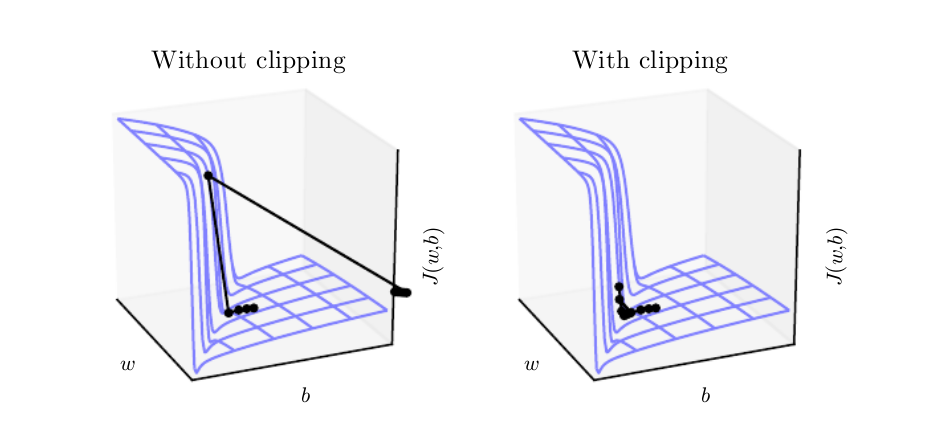

You can check the math details [here](https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem)

```python
trainer = pl.Trainer(
    gradient_clip_val=1.0
)
```


### Gradient accumulation

1. **Accumulate Gradients:**  
   During training, after processing each mini-batch, you compute the gradients but do not immediately update the model parameters. Instead, you add the gradients into a cumulative gradient buffer.

2. **Parameter Update After Several Batches:**  
   Once you have processed a predefined number of mini-batches, say $N$, the accumulated gradients are averaged and used to update the model parameters. Mathematically, if $g_i$ is the gradient from the $i$-th mini-batch, the average gradient is computed as:

   $$
   g_{\text{avg}} = \frac{1}{N} \sum_{i=1}^{N} g_i
   $$

3. **Reset the Gradient Buffer:**  
   After the update, the gradient buffer is reset to zero so that the accumulation process can start over for the next set of mini-batches.



Lightning examples:
```python
trainer = Trainer(accumulate_grad_batches=8) #it will accumulate every 8 batches.
```


```python
from lightning.pytorch.callbacks import GradientAccumulationScheduler

# till 5th epoch, it will accumulate every 8 batches. From 5th epoch
# till 9th epoch it will accumulate every 4 batches and after that no accumulation
accumulator = GradientAccumulationScheduler(scheduling={0: 8, 4: 4, 8: 1})
trainer = Trainer(callbacks=accumulator)
```


## Stochastic Weight Averaging (SWA)

Stochastic Weight Averaging (SWA) is a technique designed to improve the generalization of deep neural networks. Instead of relying solely on the final weights obtained at the end of training, SWA collects and averages weights from multiple points along the training trajectory. This process results in a more robust and smoother model.

During training, the model weights are periodically saved, especially in the later stages. The final SWA weights are computed as the average of these collected weights. Mathematically, if $W_i$ represents the model weights at the $i$-th checkpoint and there are $N$ such checkpoints, then the SWA weights are given by:

$$
W_{\text{swa}} = \frac{1}{N} \sum_{i=1}^{N} W_i
$$

This averaging tends to smooth out the fluctuations and noise present in the individual weight configurations, leading to improved generalization.

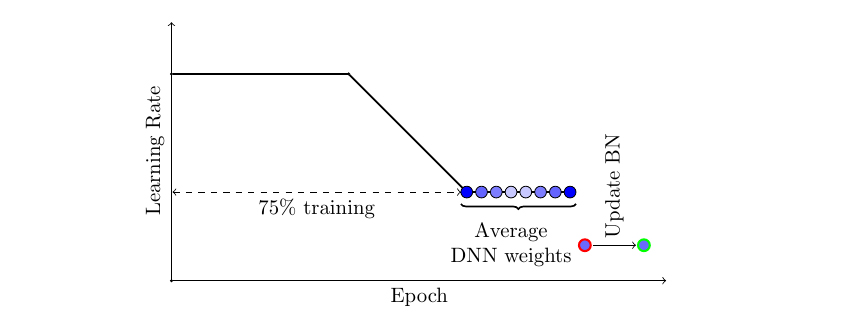

You can check more for [raw torch](https://pytorch.org/blog/pytorch-1.6-now-includes-stochastic-weight-averaging/)
or for [lightning](https://lightning.ai/docs/pytorch/stable/advanced/training_tricks.html)

```python
trainer = Trainer(callbacks=[StochasticWeightAveraging(swa_lrs=1e-2)])
```


## Distributed Data Parallel (DDP) Training

Distributed Data Parallel (DDP) is a strategy in PyTorch for training neural networks across multiple GPUs or nodes by distributing the workload across different processes. Each process handles a subset of the data and maintains a replica of the model. During training, DDP synchronizes gradients across these processes to ensure that each model replica is updated consistently.

- **Process-per-GPU:**  
  DDP spawns one process for each GPU, allowing each GPU to operate independently on its portion of the data.

- **Gradient Synchronization:**  
  After computing gradients for a mini-batch, DDP automatically synchronizes these gradients across all processes using efficient collective communication, ensuring consistent updates.

- **Scalability:**  
  DDP is highly scalable and is especially effective in single-node multi-GPU setups. It can also be extended to multi-node environments with proper configuration.


```python
Trainer(accelerator="gpu", devices=8, strategy="ddp")
```

You can find more details [here](https://lightning.ai/pages/community/tutorial/distributed-training-guide/) and [here](https://lightning.ai/docs/pytorch/stable/accelerators/gpu_intermediate.html)


## Fully Sharded Data Parallel (FSDP) Training

Fully Sharded Data Parallel (FSDP) is a distributed training technique in PyTorch designed to optimize memory usage when training large models. By sharding model parameters, gradients, and optimizer states across multiple GPUs, FSDP allows you to train models that might not otherwise fit into a single GPU's memory.

- **Parameter Sharding:**  
  FSDP divides the model parameters among available GPUs. Each GPU only holds a fraction of the full model, reducing memory requirements.

- **Gradient and Optimizer State Sharding:**  
  In addition to parameters, gradients and optimizer states are also sharded. This further reduces memory overhead during training.

- **On-the-fly Gathering:**  
  For computations during the forward and backward passes, FSDP temporarily gathers the necessary parameters. Once the computation is complete, the parameters are sharded again to maintain efficiency.


More details about [fsdp training](https://lightning.ai/docs/pytorch/stable/advanced/model_parallel/fsdp.html)

```python
from lightning.pytorch.strategies import FSDPStrategy
strategy = FSDPStrategy(
    # Default: Shard weights, gradients, optimizer state (1 + 2 + 3)
    sharding_strategy="FULL_SHARD",
    # Shard gradients, optimizer state (2 + 3)
    sharding_strategy="SHARD_GRAD_OP",
    # Don't shard anything (similar to DDP)
    sharding_strategy="NO_SHARD",
)
trainer = L.Trainer(..., strategy=strategy)
```


## Mixed Precision Training

Mixed precision training leverages both 16-bit and 32-bit floating point computations to reduce memory usage and speed up training, without sacrificing model accuracy. PyTorch Lightning makes it easy to enable mixed precision by simply specifying a precision level when creating the `Trainer`.

- **Reduced Memory Footprint:**  
  Using 16-bit precision for parts of the computation allows you to train larger models or use larger batch sizes.
  
- **Faster Training:**  
  Some of the hardware optimized for lower precision arithmetic (like NVIDIA's Tensor Cores) can execute 16-bit operations faster, improving overall training speed (e.g. A100/H100 with bf16 format).
  
- **Maintained Accuracy:**  
  Automatic loss scaling ensures numerical stability, so model accuracy is maintained.

```python
Trainer(..., precision=16)
```